In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import integrate
from scipy.interpolate import UnivariateSpline
%matplotlib inline

from astropy import constants as const
from astropy import units as u

figsize = 4.5
dpi = 300

default_font = 18
plt.rcParams.update({
    'font.size': default_font,  # This sets the default font size for everything
    'axes.titlesize': default_font,
    'axes.labelsize': default_font,
    'xtick.labelsize': default_font,
    'ytick.labelsize': default_font,
    'legend.fontsize': default_font,
    'figure.titlesize': default_font
})


plt.style.use('style_prof2.mplstyle')

## Get the model

names = ['m','r','T','rho','P','l','X_H','X_He4','X_He3','X_C12','X_N14','X_O16','X_7Be','nu pp','nu B8','nu N13','nu O15','nu F17','nu Be7','nu pep','nu hep']
df_solar_model = pd.read_csv('Smoothed_Solar_Model.csv',names=names,skiprows=1,index_col=False)

SSM_r = np.array(df_solar_model['r'])
SSM_T = np.array(df_solar_model['T'])
SSM_rho = np.array(df_solar_model['rho'])
SSM_P = np.array(df_solar_model['P'])
SSM_H = np.array(df_solar_model['X_H'])
SSM_He4 = np.array(df_solar_model['X_He4'])
SSM_He3 = np.array(df_solar_model['X_He3'])
SSM_C12 = np.array(df_solar_model['X_C12'])
SSM_N14 = np.array(df_solar_model['X_N14'])
SSM_O16 = np.array(df_solar_model['X_O16'])
SSM_Be7 = np.array(df_solar_model['X_7Be'])

In [2]:
SSM_r = np.array(pd.read_csv('Smoothing/X_7Be.csv',names=['r','q'],skiprows=1,index_col=False)['r'])
SSM_T = np.array(pd.read_csv('Smoothing/T.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_rho = np.array(pd.read_csv('Smoothing/rho.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_P = np.array(pd.read_csv('Smoothing/P.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_H = np.array(pd.read_csv('Smoothing/X_H.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_He4 = np.array(pd.read_csv('Smoothing/X_He4.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_He3 = np.array(pd.read_csv('Smoothing/X_He3.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_C12 = np.array(pd.read_csv('Smoothing/X_C12.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_N14 = np.array(pd.read_csv('Smoothing/X_N14.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_O16 = np.array(pd.read_csv('Smoothing/X_N16.csv',names=['r','q'],skiprows=1,index_col=False)['q'])
SSM_Be7 = np.array(pd.read_csv('Smoothing/X_7Be.csv',names=['r','q'],skiprows=1,index_col=False)['q'])

## Get S Factors

In [3]:
S11 = 4.09e-25 * u.MeV * u.barn
S11_prime = S11 * 11 * u.MeV**(-1)
S11_dbl_prime = S11 * 242 * u.MeV**(-2)

S12 = 2.028 * u.MeV * u.barn
S12_prime = 0 * u.barn
S12_dbl_prime = 0 * u.barn * u.MeV**(-1)

S33_func = lambda E: (5.21 - 4.90 * (E/u.MeV) + 11.21 * (E/u.MeV)**2) * u.MeV * u.barn
S33_prime_func = lambda E: (- 4.90 + 2*11.21 * (E/u.MeV)) * u.barn
S33 = S33_func(0*u.MeV)
S33_prime = S33_prime_func(0*u.MeV)
S33_dbl_prime = 2*11.21 * u.MeV**(-1) * u.barn

S34 = 0.561 * u.keV * u.barn
S34_prime = S34 * -0.54 * u.MeV**(-1)
S34_dbl_prime = 0 * u.barn * u.MeV**(-1)

Shep = 8.6e-20 * u.keV * u.barn
Shep_prime = 0 * u.barn
Shep_dbl_prime = 0 * u.barn * u.MeV**(-1)

S17 = 20.5 * u.eV * u.barn
S17_prime = 0 * u.barn
S17_dbl_prime = 0 * u.barn* u.eV**(-1)

S114 = 1.68 * u.keV * u.barn
S114_prime = 0 * u.barn
S114_dbl_prime = 0 * u.barn* u.MeV**(-1)

S112 = 1.44 * u.keV * u.barn
S112_prime = 0 * u.barn
S112_dbl_prime = 0 * u.barn* u.MeV**(-1)

S116 = 10.92 * u.keV * u.barn
S116_prime = 0 * u.barn
S116_dbl_prime = 0 * u.barn * u.MeV**(-1)


## Calculate a reaction

In [4]:
def T_6(T):
    return T/1e6

def tau(T,Z1,Z2,A):
    return 42.487 * (Z1**2 * Z2**2 * A * T_6(T)**-1)**(1/3)

def E0(T,Z1,Z2,A):
    return 1.2204 * (Z1**2 * Z2**2 * A * T_6(T)**2) **(1/3) * u.keV

def S_eff(T,S,Sp,Spp,Z1,Z2,A):
    E_0 = E0(T,Z1,Z2,A)
    term1 = (1 + 5/(12*tau(T,Z1,Z2,A)))
    #print(term1.unit)
    term2 = Sp*(E_0 + 35/36 * const.k_B * T * u.K)/S
    #print(term2.unit)
    term3 = Spp*E_0/S * (E_0/2 + 89/72 * const.k_B*T*u.K)
    #print(term3.unit)
    sum_of_terms = S*(term1 + term2 + term3)
    unitful_sum = sum_of_terms.to('keV barn')
    return (unitful_sum).value

def zeta(reactant1, reactant2, Z1, A1, Z2, A2):
    projectile = reactant1*Z1**2 /A1 + reactant1*Z1/A1
    target = reactant2*Z2**2 /A2 + reactant2*Z2/A2
    return np.sqrt(projectile + target)

def f_0(reactant1, reactant2, Z1, A1, Z2, A2,T,rho):
    return np.exp(0.188 * Z1*Z2 * zeta(reactant1, reactant2, Z1, A1, Z2, A2) * rho**(1/2) * T_6(T)**(-3/2))

def sigma_v(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp):
    A = (A1*A2)/(A1 + A2)
    screening = f_0(reactant1, reactant2, Z1, A1, Z2, A2,SSM_T,SSM_rho)
    s_factor = S_eff(SSM_T,S,Sp,Spp,Z1,Z2,A)

    return 1.3005e-15 * (Z1*Z2/(A*T_6(SSM_T)**2))**(1/3) * screening * s_factor * np.exp(-tau(SSM_T,Z1,Z2,A)) * u.cm**(3) * u.s**(-1)

def reactionRate(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp,m1,m2):
    n1 = SSM_rho*u.g*u.cm**(-3) * reactant1 / m1
    n2 = SSM_rho*u.g*u.cm**(-3) * reactant2 / m2
    if reactant1[0] == reactant2[0]:
        correction = 1/2
    else:
        correction = 1
    return n1 * n2 * correction * sigma_v(reactant1, reactant2, Z1, Z2, A1, A2, S,Sp,Spp)

## Plot reaction rate

In [5]:
SSM_radius_cm = 6.597e10*SSM_r

In [6]:
def plotReaction(x,y,x_label,y_label,normalization,title,filename):
    fig, ax = plt.subplots(1, 1, figsize=(figsize, figsize),dpi=dpi)
    ax.plot(x,y/(10**normalization),lw=1.5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xlim(0,0.3)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))
    plt.show()


# The proton-proton chain

## $^{7}$Be + p

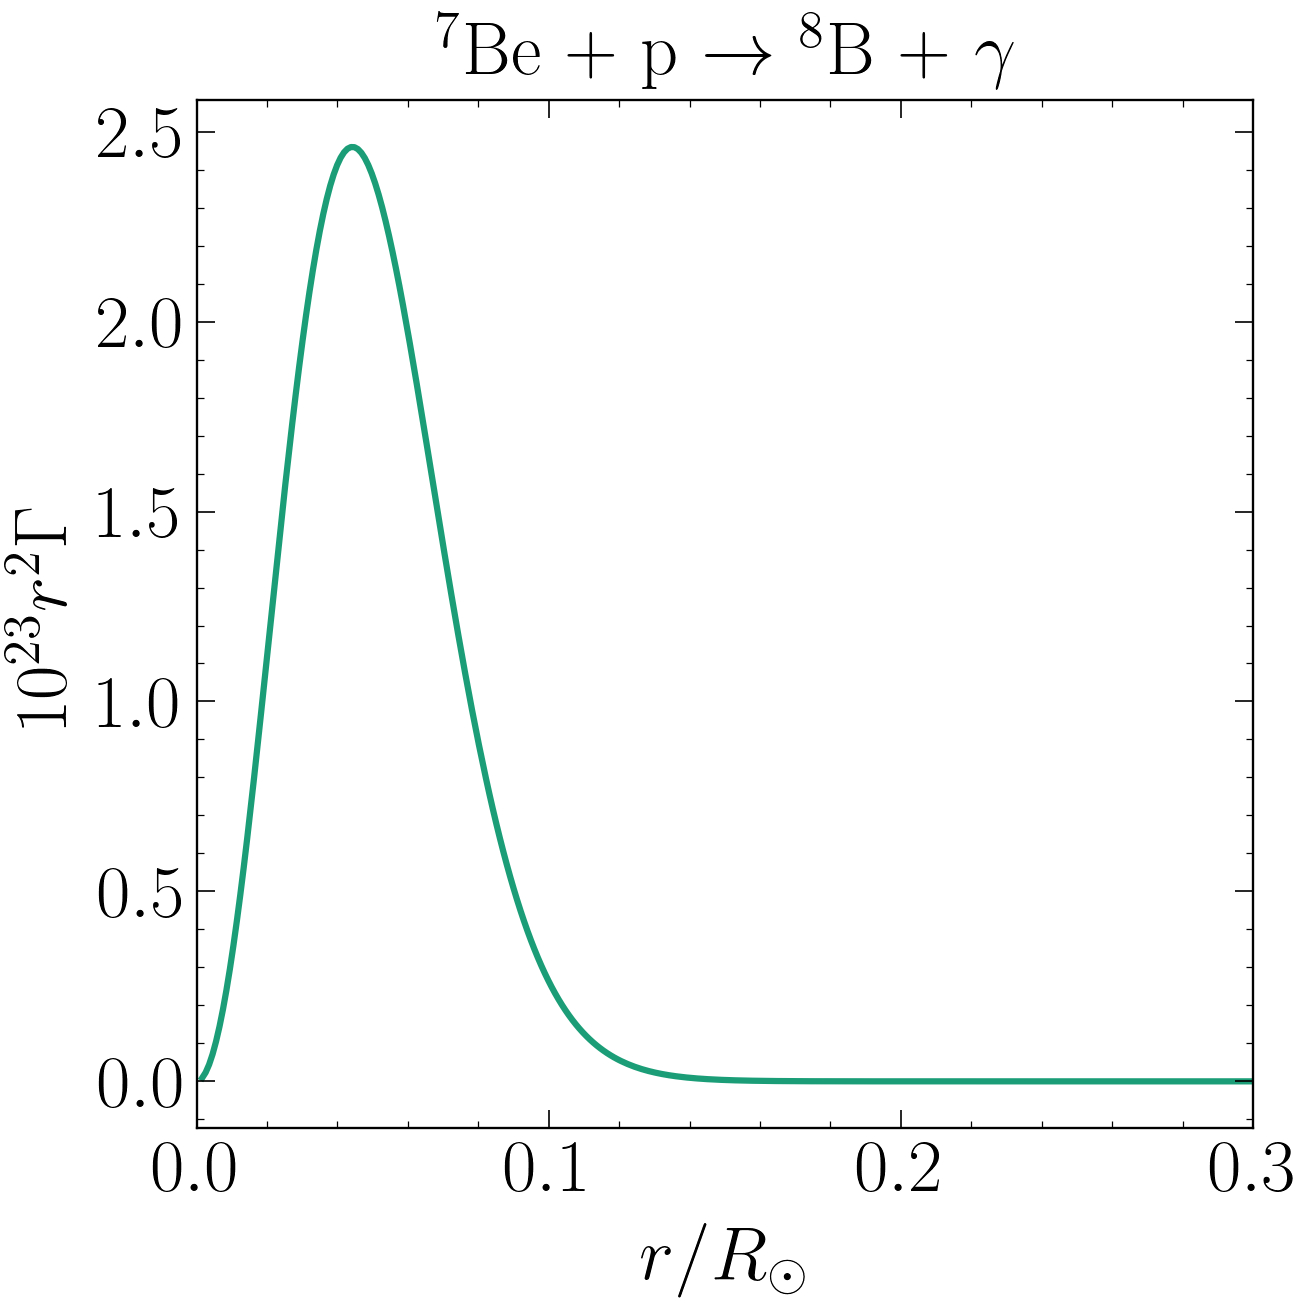

In [14]:
Z_H = 1
Z_Be7 = 4
A_H = 1
A_Be7 = 7
m_H = 1.6738e-24 * u.g
m_Be7 = 1.165e-23 * u.g

Be7p = reactionRate(SSM_H, SSM_Be7, Z_H, Z_Be7, A_H, A_Be7, S17,S17_prime,S17_dbl_prime,m_H,m_Be7)

title = r'$^{7}$Be + p $\rightarrow$ $^{8}$B + $\gamma$'

plotReaction(SSM_r,Be7p*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{23} r^2 \Gamma$',23,title,'Images/Reaction Rates/8B_rate')

Export $^8$B to file:

In [15]:
rate_out = pd.DataFrame({"Radius":SSM_r,"Reaction Rate":Be7p*SSM_radius_cm**2})
rate_out.to_csv('8BZone.csv',index = False)

## p + p

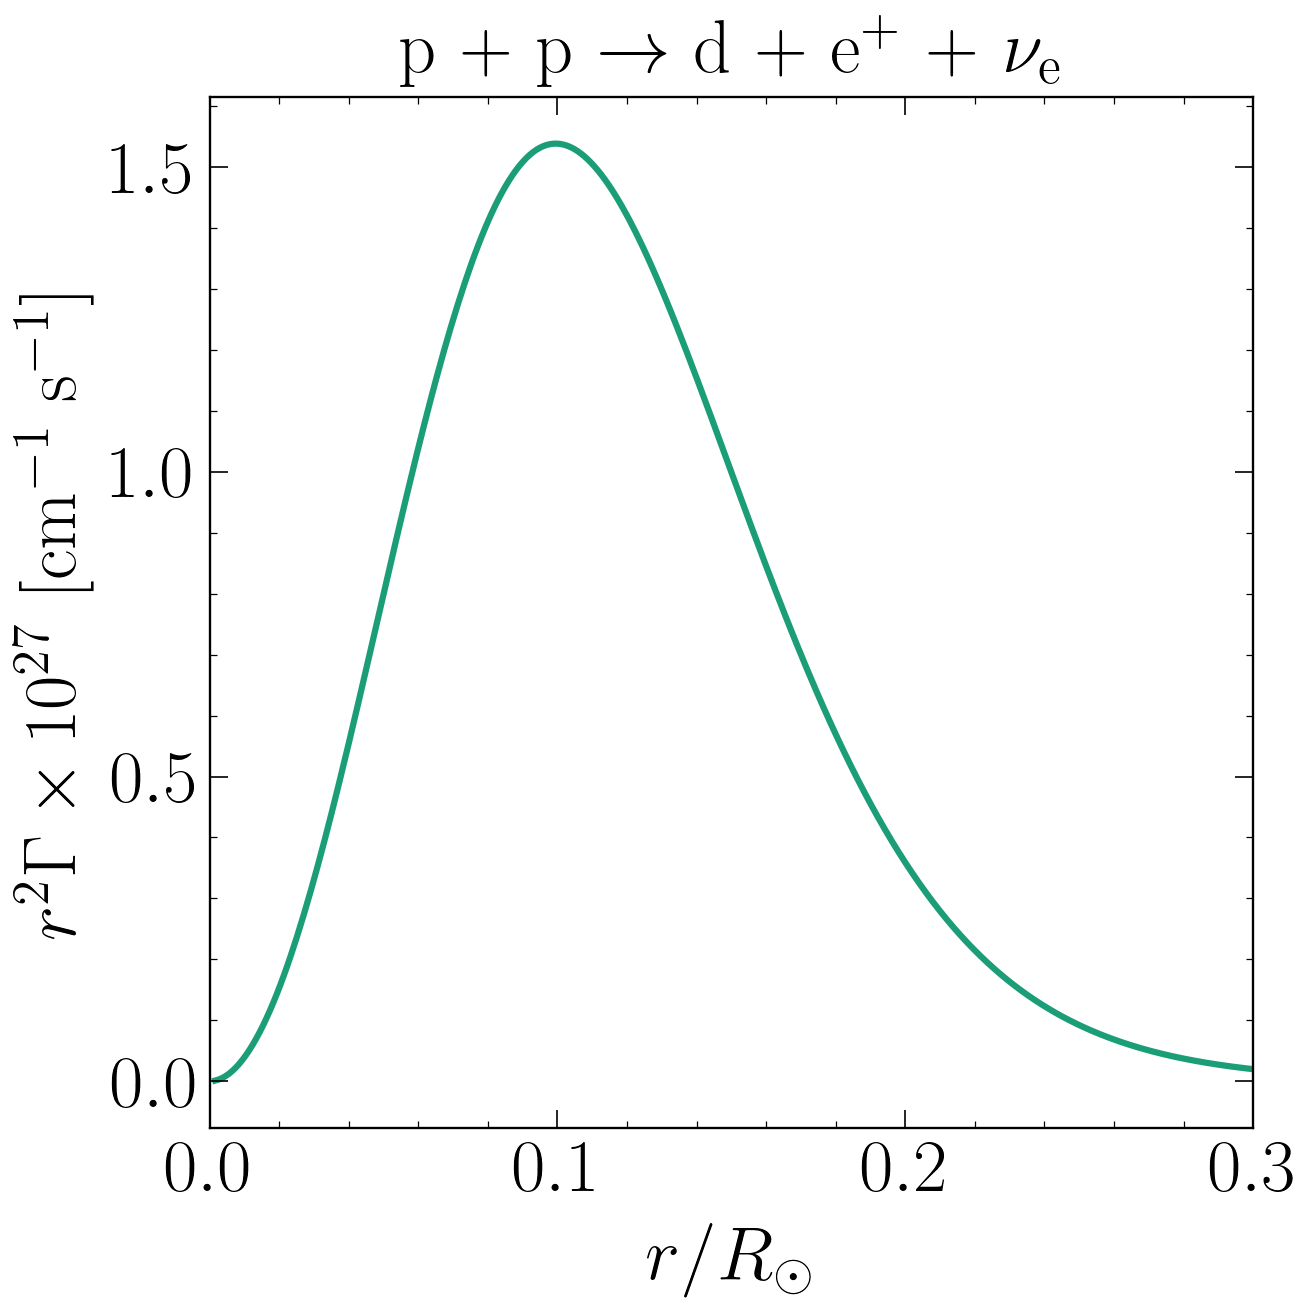

In [8]:
Z_H = 1
A_H = 1
m_H = 1.6738e-24 * u.g

pp = reactionRate(SSM_H, SSM_H, Z_H, Z_H, A_H, A_H, S11,S11_prime,S11_dbl_prime,m_H,m_H)

title = r'p + p $\rightarrow$ d + e$^+$ + $\nu_\mathrm{e}$'

plotReaction(SSM_r,pp*SSM_radius_cm**2,r'$r/R_\odot$',r'$r^2 \Gamma \times 10^{27}$ [cm$^{-1}$ s$^{-1}$]',27,title,'Images/Reaction Rates/pp_rate')

## hep

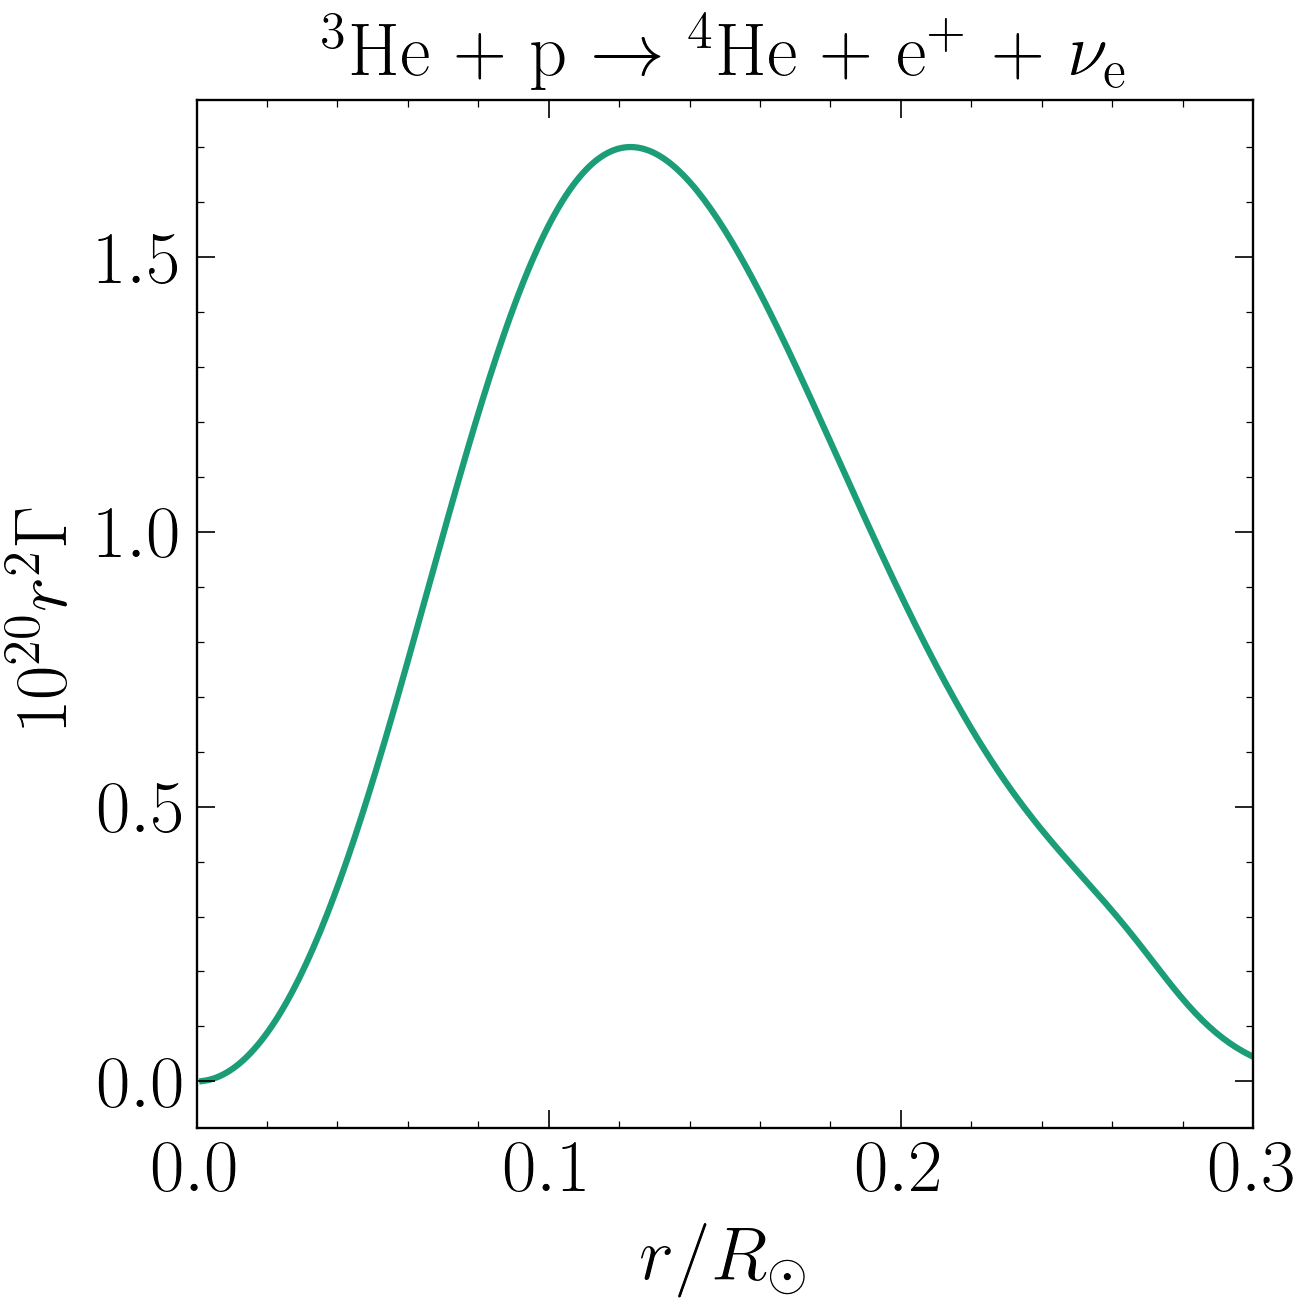

In [10]:
Z_H = 1
Z_He3 = 2
A_H = 1
A_He3 = 3
m_H = 1.6738e-24 * u.g
m_He3 = 5.008e-24 * u.g

hep = reactionRate(SSM_H, SSM_He3, Z_H, Z_He3, A_H, A_He3, Shep,Shep_prime,Shep_dbl_prime,m_H,m_He3)

title = r'$^{3}$He + p $\rightarrow$ $^{4}$He + e$^+$ + $\nu_\mathrm{e}$'

plotReaction(SSM_r,hep*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{20} r^2 \Gamma$',20,title,'Images/Reaction Rates/hep_rate')

Export hep to file:

In [12]:
rate_out = pd.DataFrame({"Radius":SSM_r,"Reaction Rate":hep*SSM_radius_cm**2})
rate_out.to_csv('hepZone.csv',index = False)

## $^{3}$He + $^{3}$He

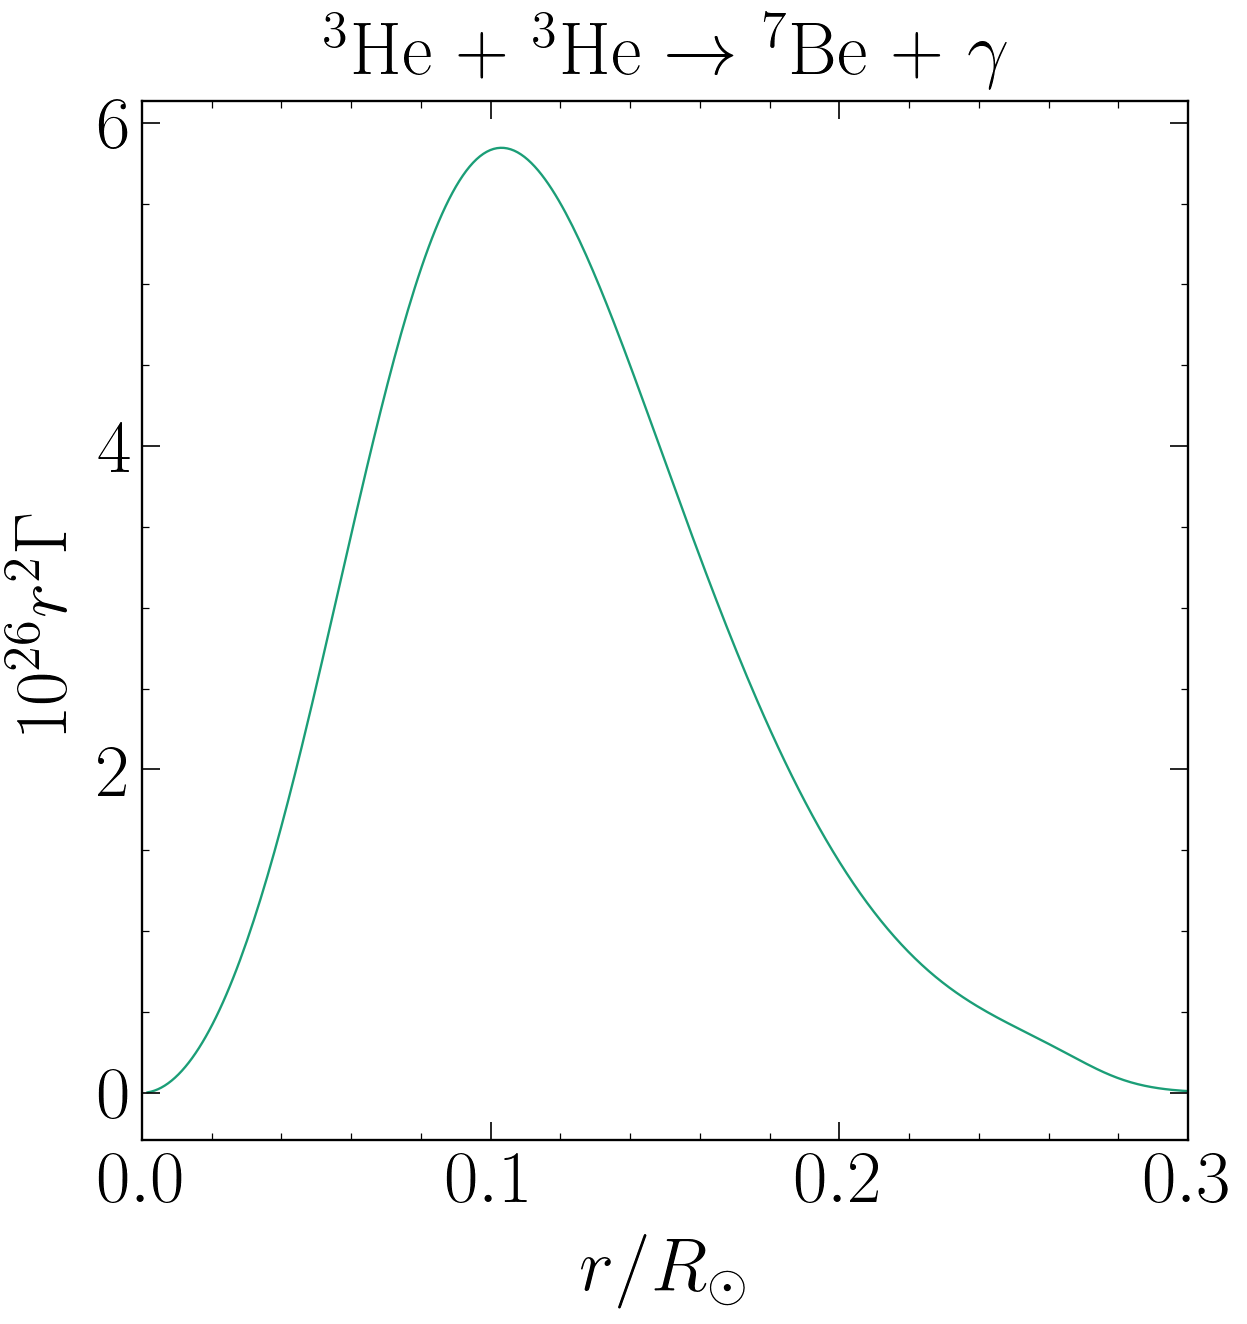

In [10]:
Z_He3 = 2
A_He3 = 3
m_He3 = 5.008e-24 * u.g

He3He3 = reactionRate(SSM_He3, SSM_He3, Z_He3, Z_He3, A_He3, A_He3, S33,S33_prime,S33_dbl_prime,m_He3,m_He3)

title = r'$^{3}$He + $^{3}$He $\rightarrow$ $^{7}$Be + $\gamma$'

plotReaction(SSM_r,He3He3*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{26} r^2 \Gamma$',26,title)

## $^{3}$He + $^{4}$He

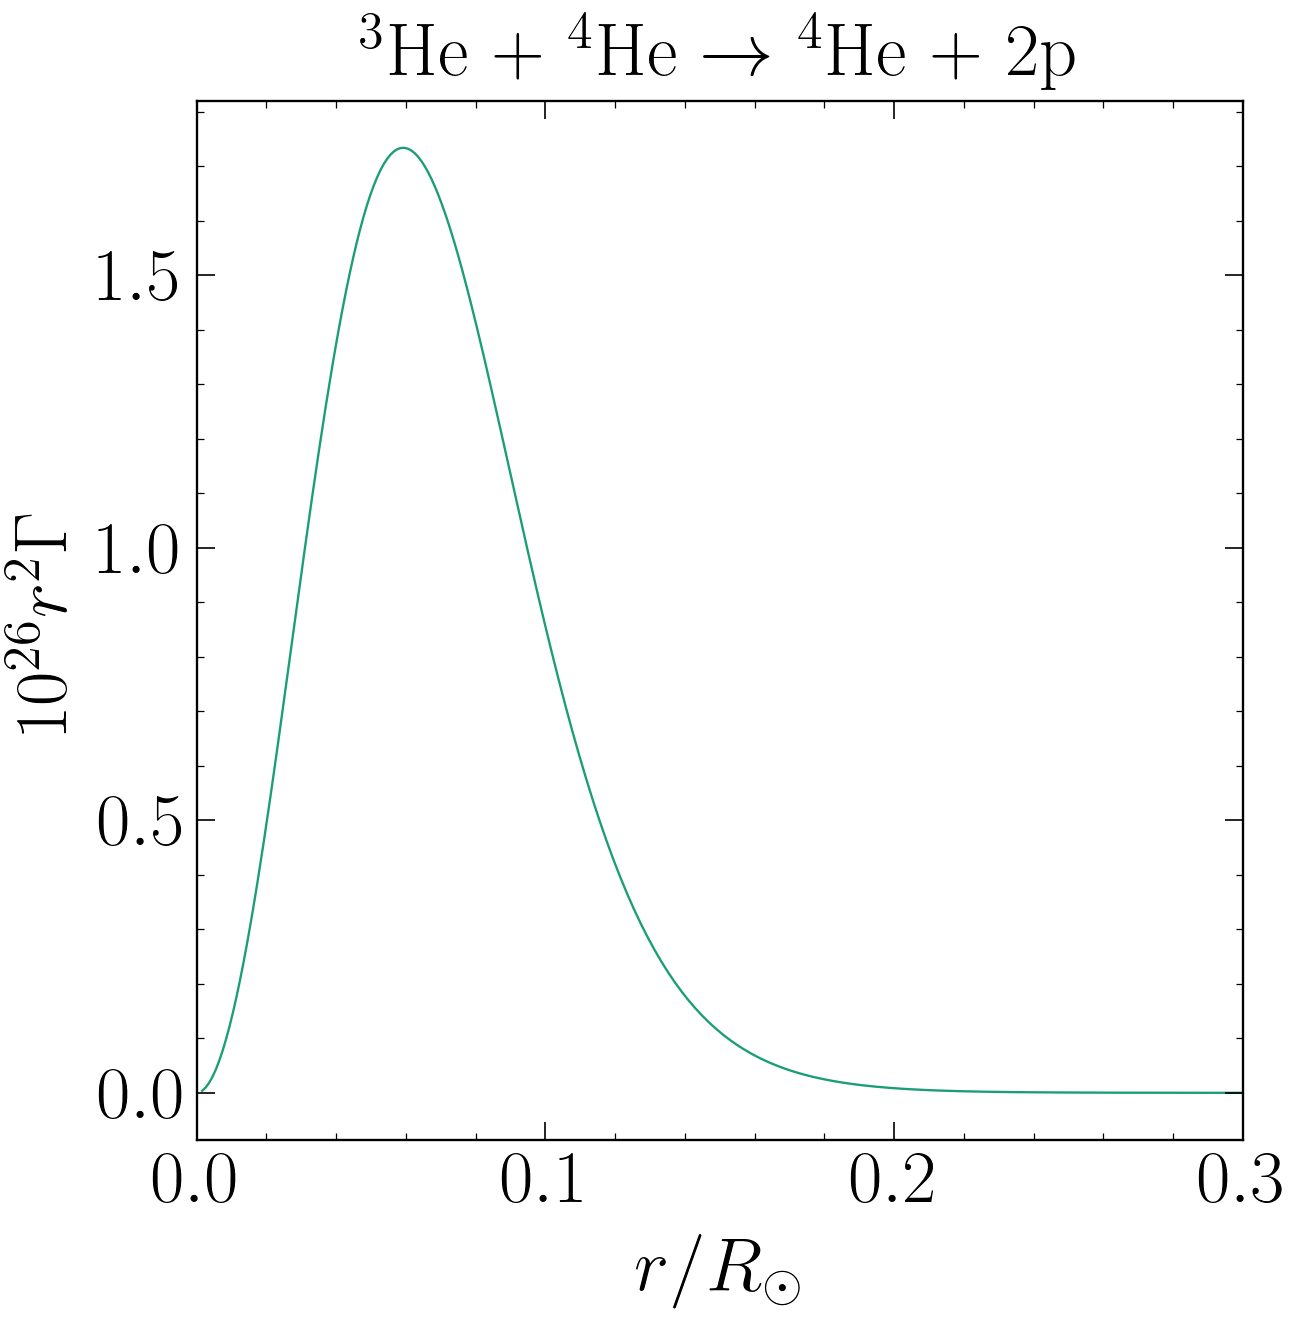

In [11]:
Z_He4 = 2
Z_He3 = 2
A_He4 = 4
A_He3 = 3
m_He4 = 6.645e-24 * u.g
m_He3 = 5.008e-24 * u.g

He3He4 = reactionRate(SSM_He4, SSM_He3, Z_He4, Z_He3, A_He4, A_He3, S34,S34_prime,S34_dbl_prime,m_He4,m_He3)

title = r'$^{3}$He + $^{4}$He $\rightarrow$ $^{4}$He + 2p'

plotReaction(SSM_r,He3He4*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{26} r^2 \Gamma$',26,title)

## pep

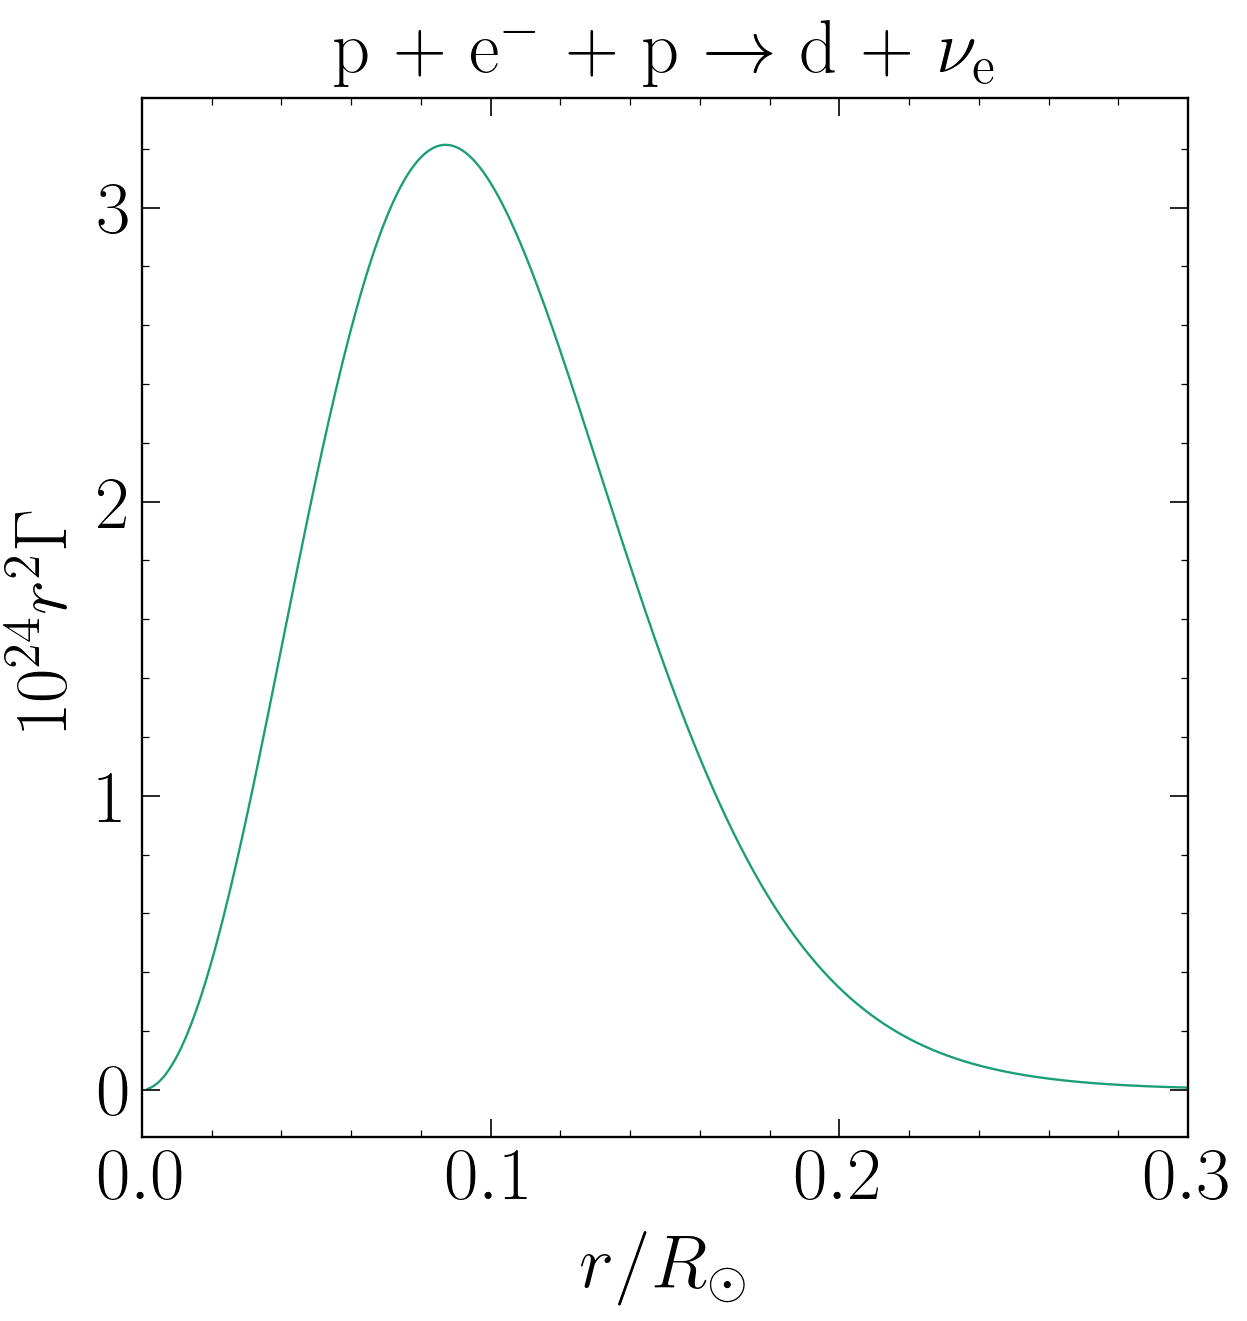

In [12]:
pep = 1.130e-4 * (SSM_rho/(2/(1+SSM_H))) * T_6(SSM_T)**(-1/2) * (1 + 0.02*(T_6(SSM_T) - 16)) * pp #solar fusion 3 paper
title = r'p + e$^{-}$ + p $\rightarrow$ d + $\nu_\mathrm{e}$'

plotReaction(SSM_r,pep*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{24} r^2 \Gamma$',24,title)

## $^{7}$Be electron capture? No, this is not right.

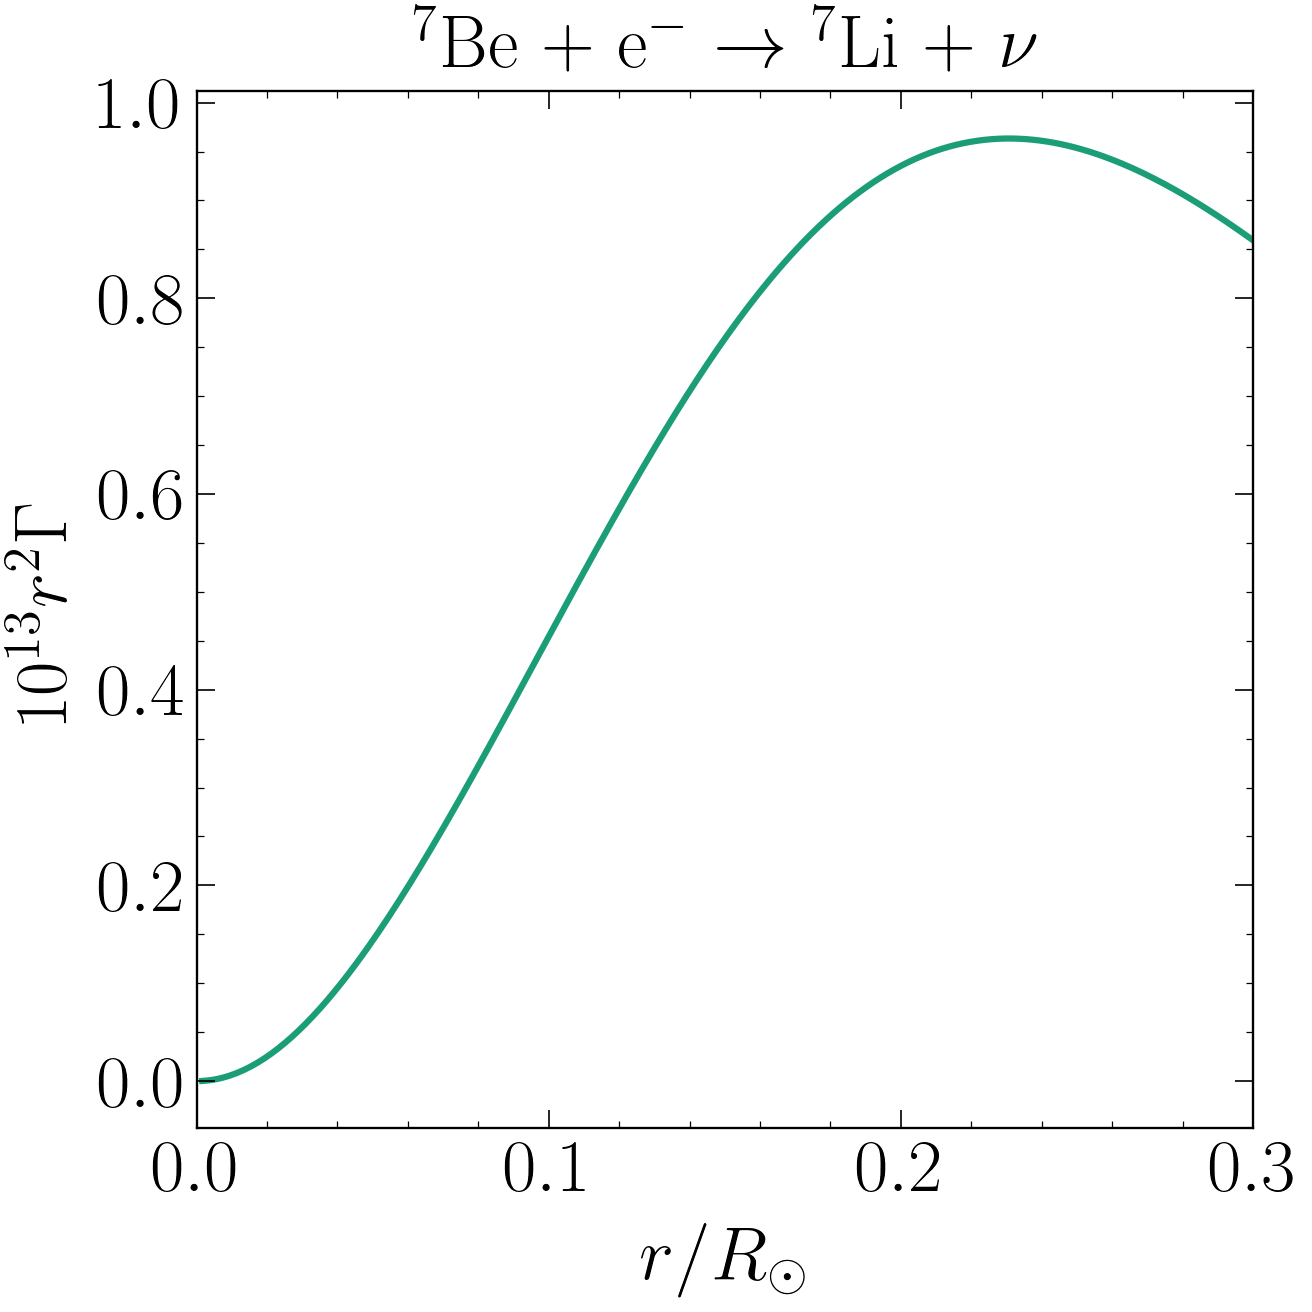

In [9]:
Be7e = 5.6 * 1e-9 * (SSM_rho/(2/(1+SSM_H))) * T_6(SSM_T)**(-1/2) * (1 + 0.004 * (T_6(SSM_T) - 16))
title = r'$^7$Be + e$^{-}$ $\rightarrow$ $^7$Li + $\nu$'
plotReaction(SSM_r,Be7e*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{13} r^2 \Gamma$',13,title,'Images/Reaction Rates/Be7_capture_rate')

# Collecting reactions of the pp chain

In [23]:
def plot_pp(rates,labels,normalizations,linestyles):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5),dpi=350)
    for i,y in enumerate(rates):
        ax.plot(SSM_r,y/(10**normalizations[i]) * SSM_radius_cm**2,label=labels[i],lw=1.5,ls=linestyles[i])
    
    ax.set_xlabel(r'$r/R_\odot$')
    ax.set_ylabel(r'$r^2 \Gamma$ [cm$^{-1}$ s$^{-1}$]')
    ax.set_title('Selected Reaction Rates of the pp Chain')
    ax.set_xlim(0,0.3)
    
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('Images/Reaction Rates/pp_rates.pdf')
    plt.show()

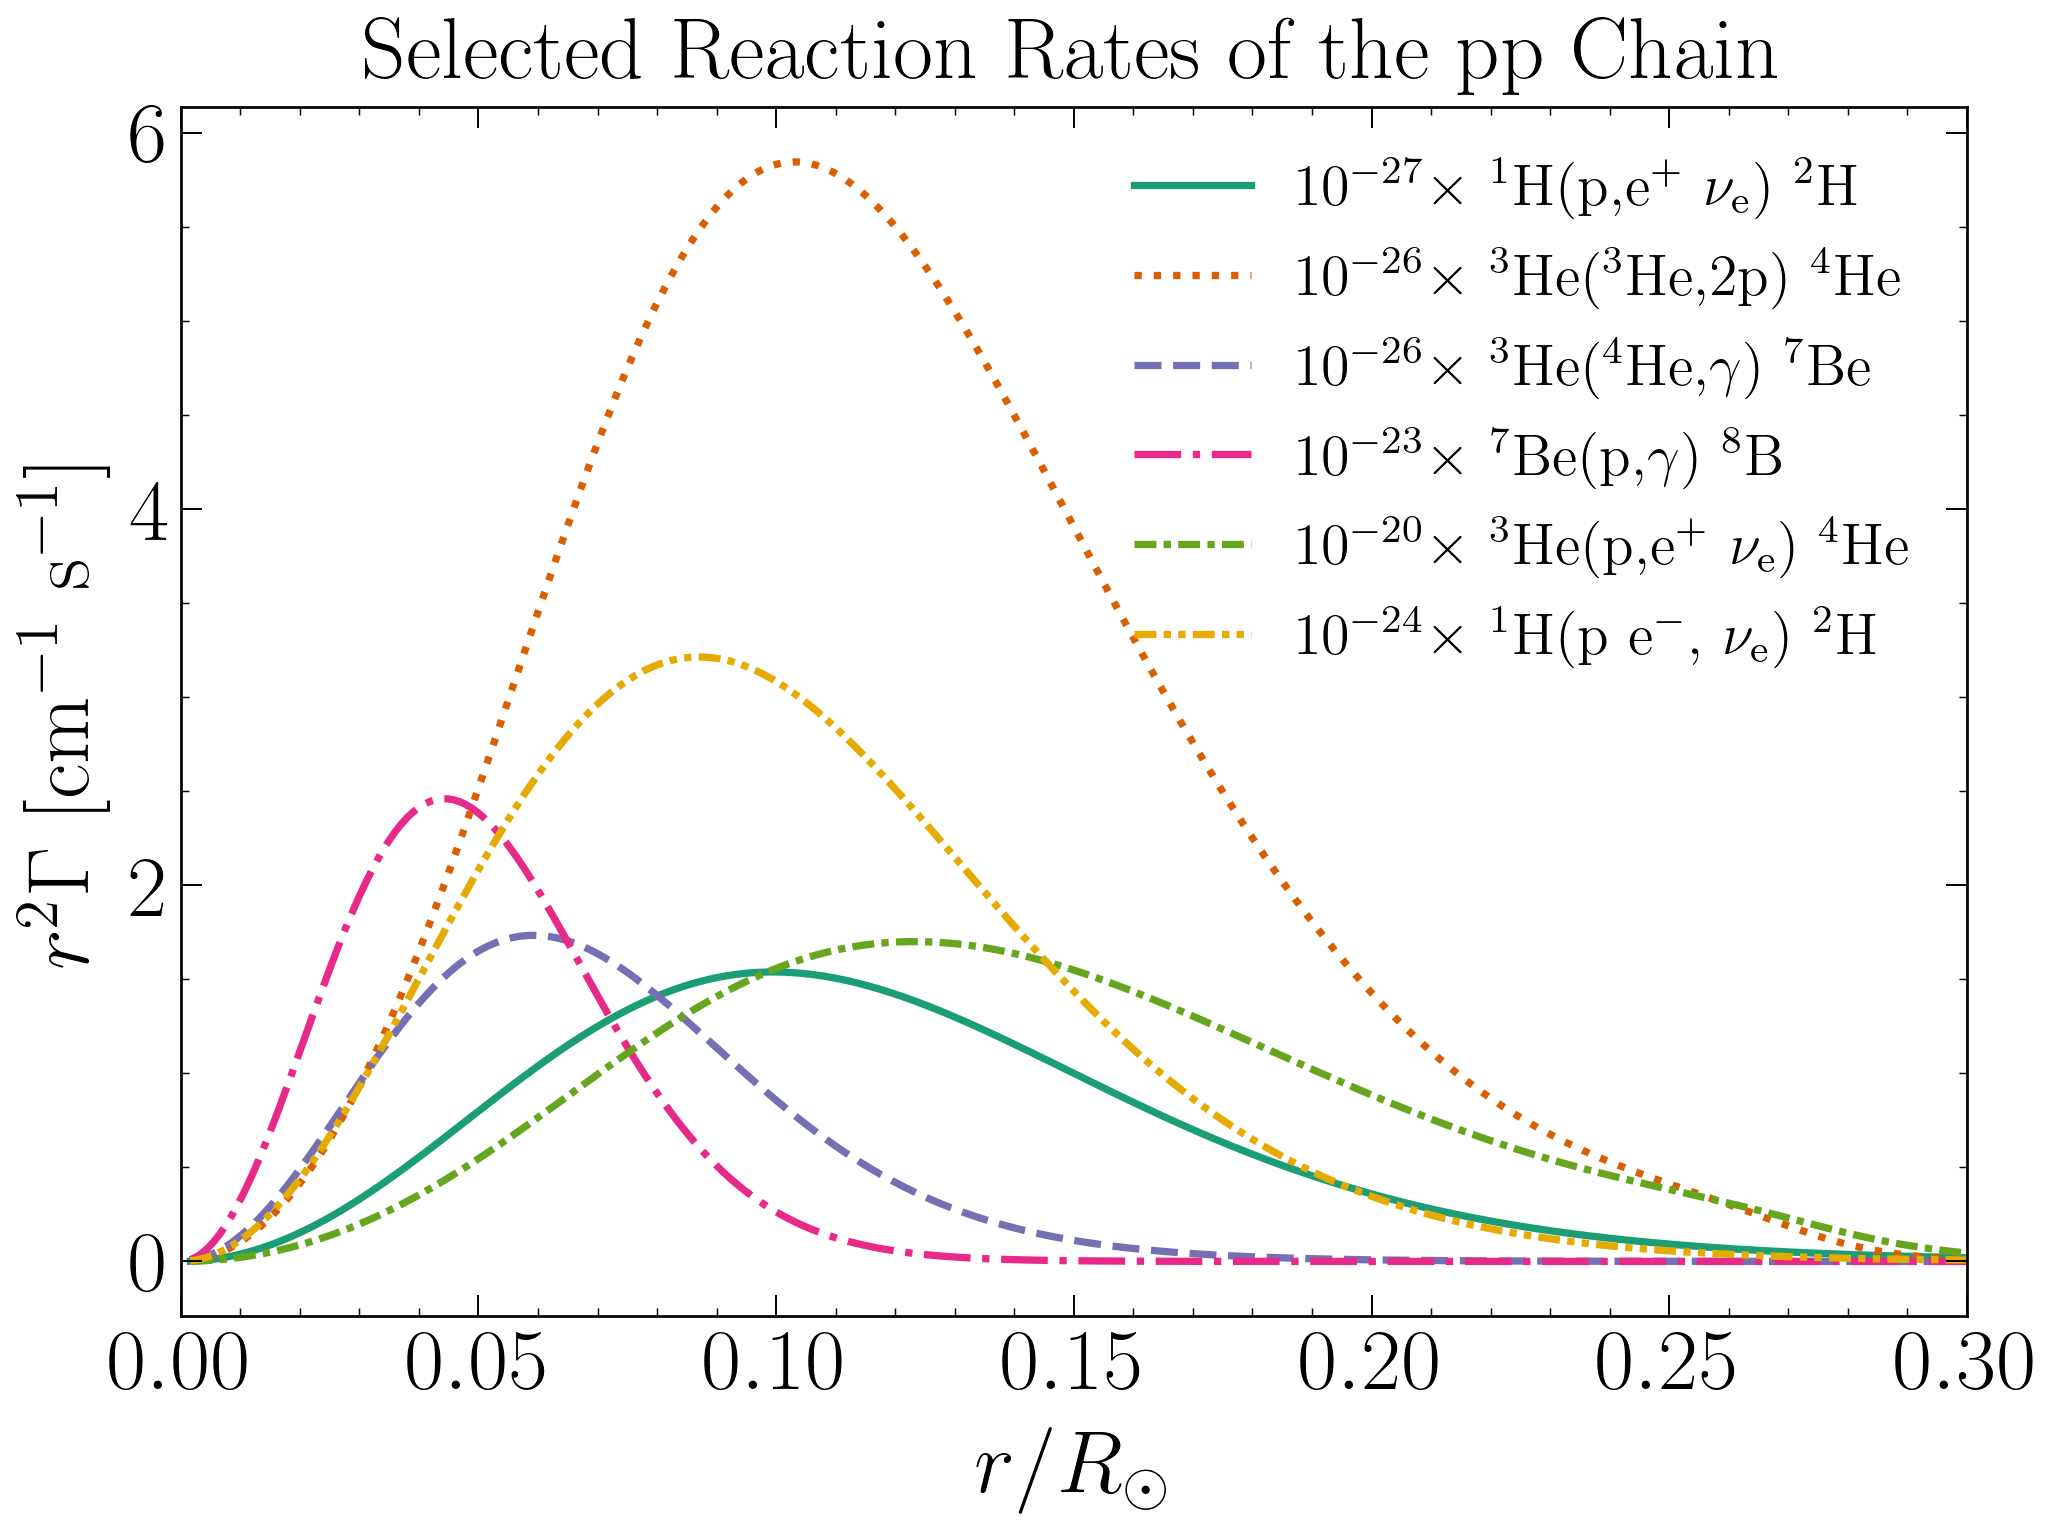

In [24]:
all_rates = [pp,He3He3,He3He4,Be7p,hep,pep]
all_labels = [r'$10^{-27} \times$ $^{1}$H(p,e$^+$ $\nu_\mathrm{e}$) $^{2}$H',r'$10^{-26} \times$ $^{3}$He($^{3}$He,2p) $^{4}$He',r'$10^{-26} \times$ $^{3}$He($^{4}$He,$\gamma$) $^{7}$Be',r'$10^{-23} \times$ $^{7}$Be(p,$\gamma$) $^{8}$B',r'$10^{-20} \times$ $^{3}$He(p,e$^+$ $\nu_\mathrm{e}$) $^{4}$He',r'$10^{-24} \times$ $^{1}$H(p e$^-$, $\nu_\mathrm{e}$) $^{2}$H']
all_normalizations = [27,26,26,23,20,24]
all_linestyles = ['solid','dotted','dashed','dashdot',(0,(3,1,1,1)),(0, (3, 1, 1, 1, 1, 1))]
plot_pp(all_rates,all_labels,all_normalizations,all_linestyles)

# The CNO bi-cycle

## $^{12}$C + p

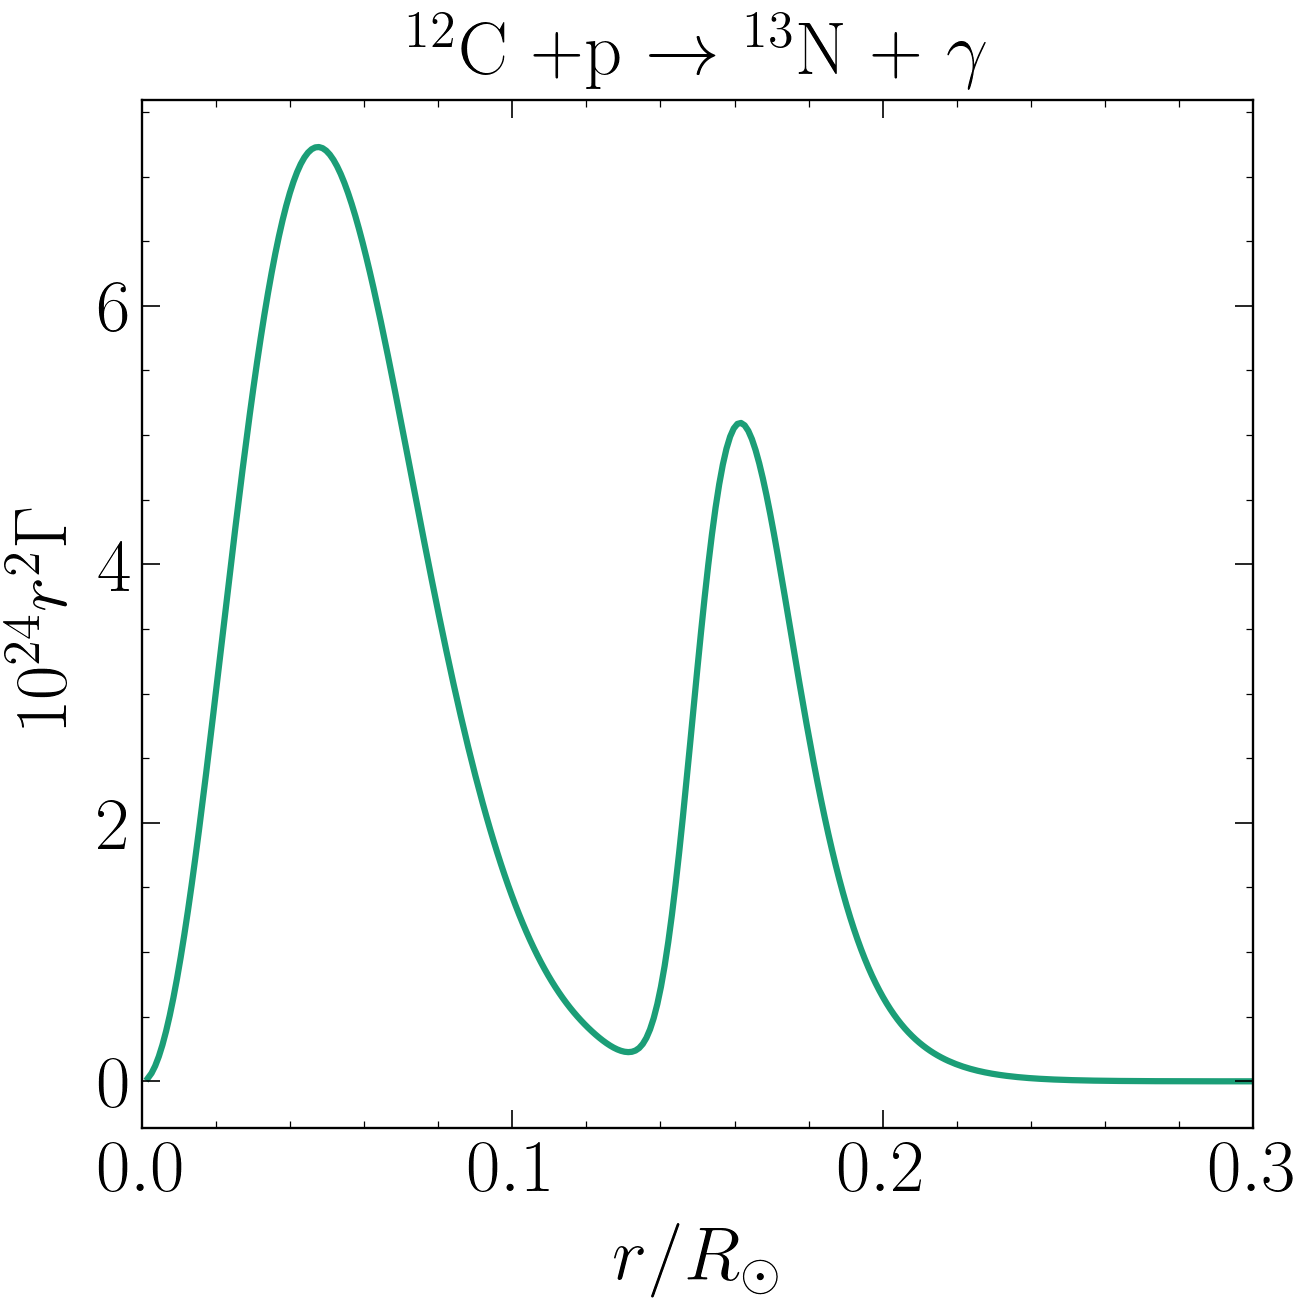

In [18]:
Z_C = 6
Z_H = 1
A_C = 12
A_H = 1
m_C12 = 1.993e-23 * u.g
m_H = 1.6738e-24 * u.g

C12p = reactionRate(SSM_C12, SSM_H, Z_C, Z_H, A_C, A_H, S112,S112_prime,S112_dbl_prime,m_C12,m_H)

title = r'$^{12}$C +p $\rightarrow$ $^{13}$N + $\gamma$'

plotReaction(SSM_r,C12p*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{24} r^2 \Gamma$',24,title,'Images/Reaction Rates/C12_rate')

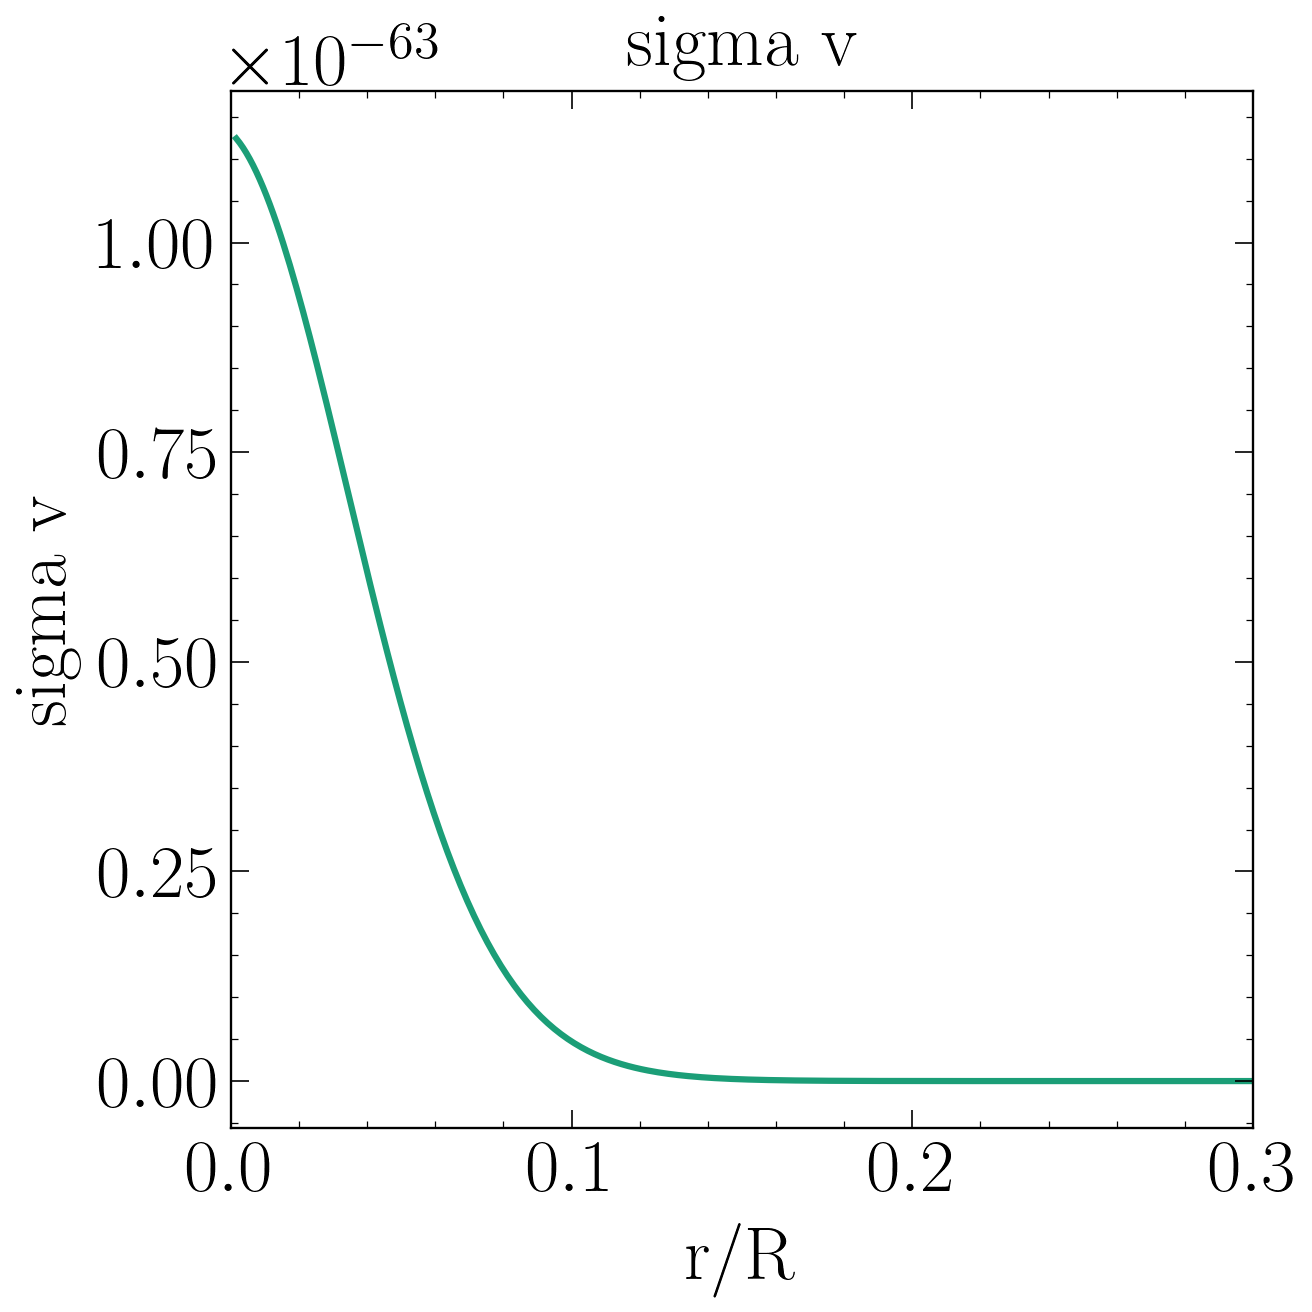

In [22]:
sigmav_C12 = sigma_v(SSM_C12, SSM_H, Z_C, Z_H, A_C, A_H, S112,S112_prime,S112_dbl_prime)

plotReaction(SSM_r,sigmav_C12,r'r/R',r'sigma v',24,'sigma v','Images/Reaction Rates/C12_sigmav')

In [23]:
n1 = SSM_rho*u.g*u.cm**(-3) * SSM_C12 / m_C12
n2 = SSM_rho*u.g*u.cm**(-3) * SSM_H / m_H

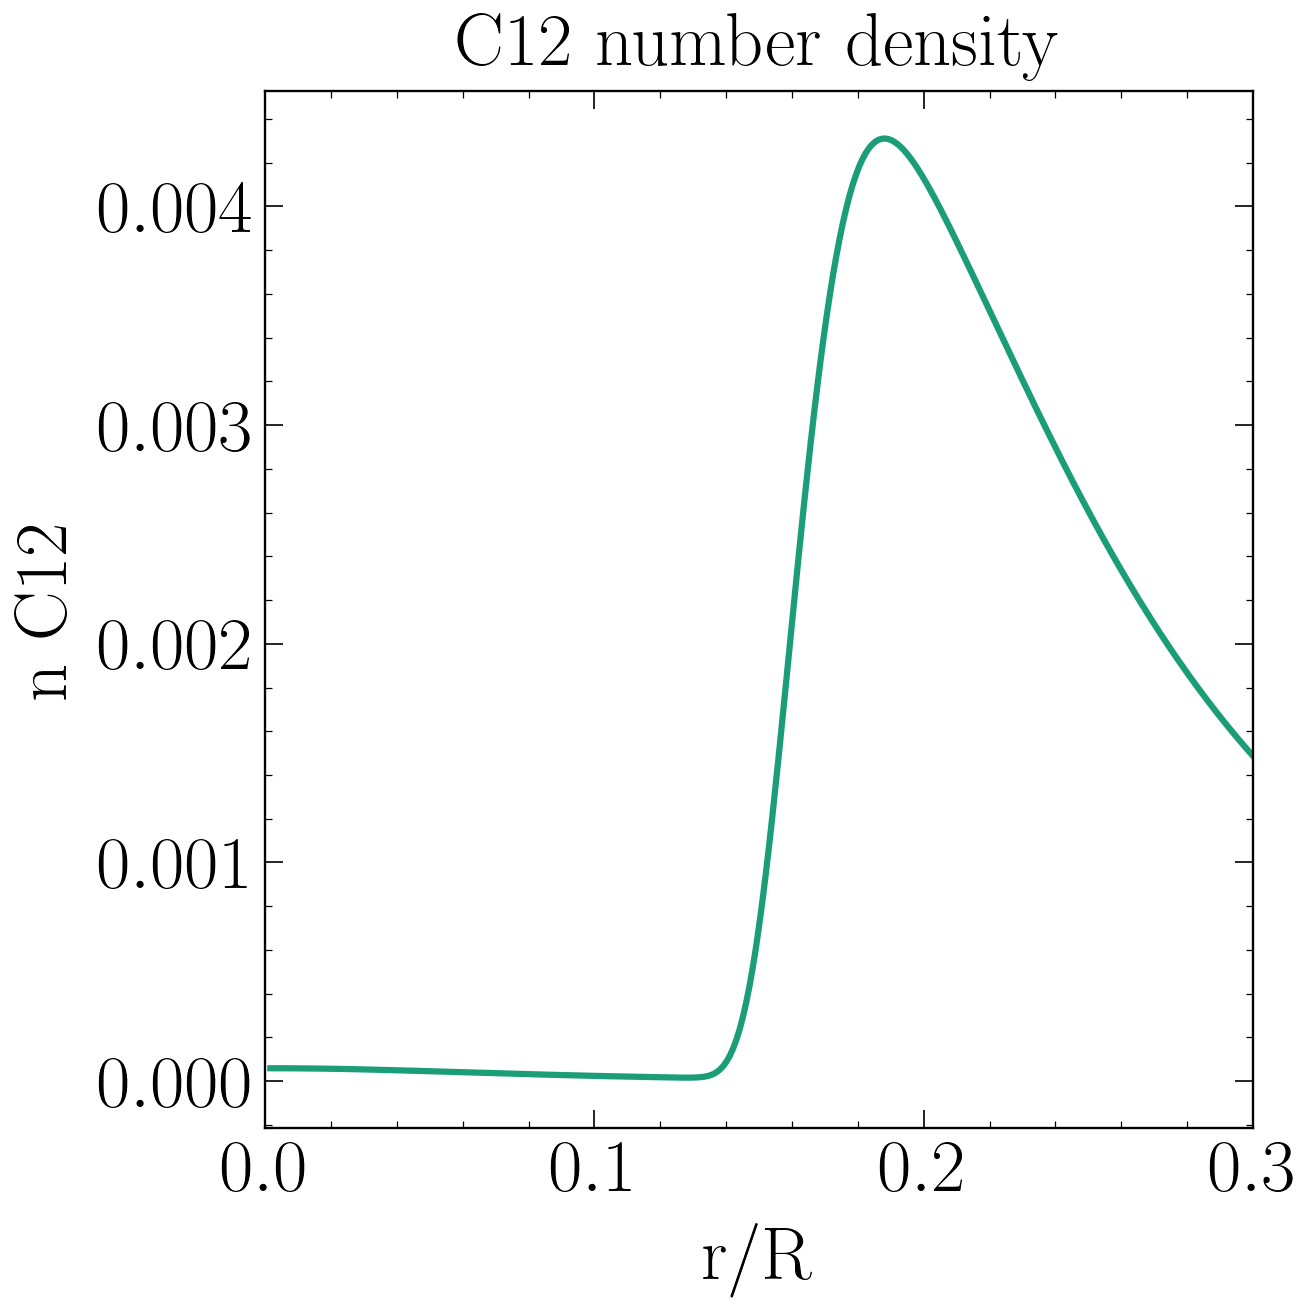

In [24]:
plotReaction(SSM_r,n1,r'r/R',r'n C12',24,'C12 number density','Images/Reaction Rates/C12_density')

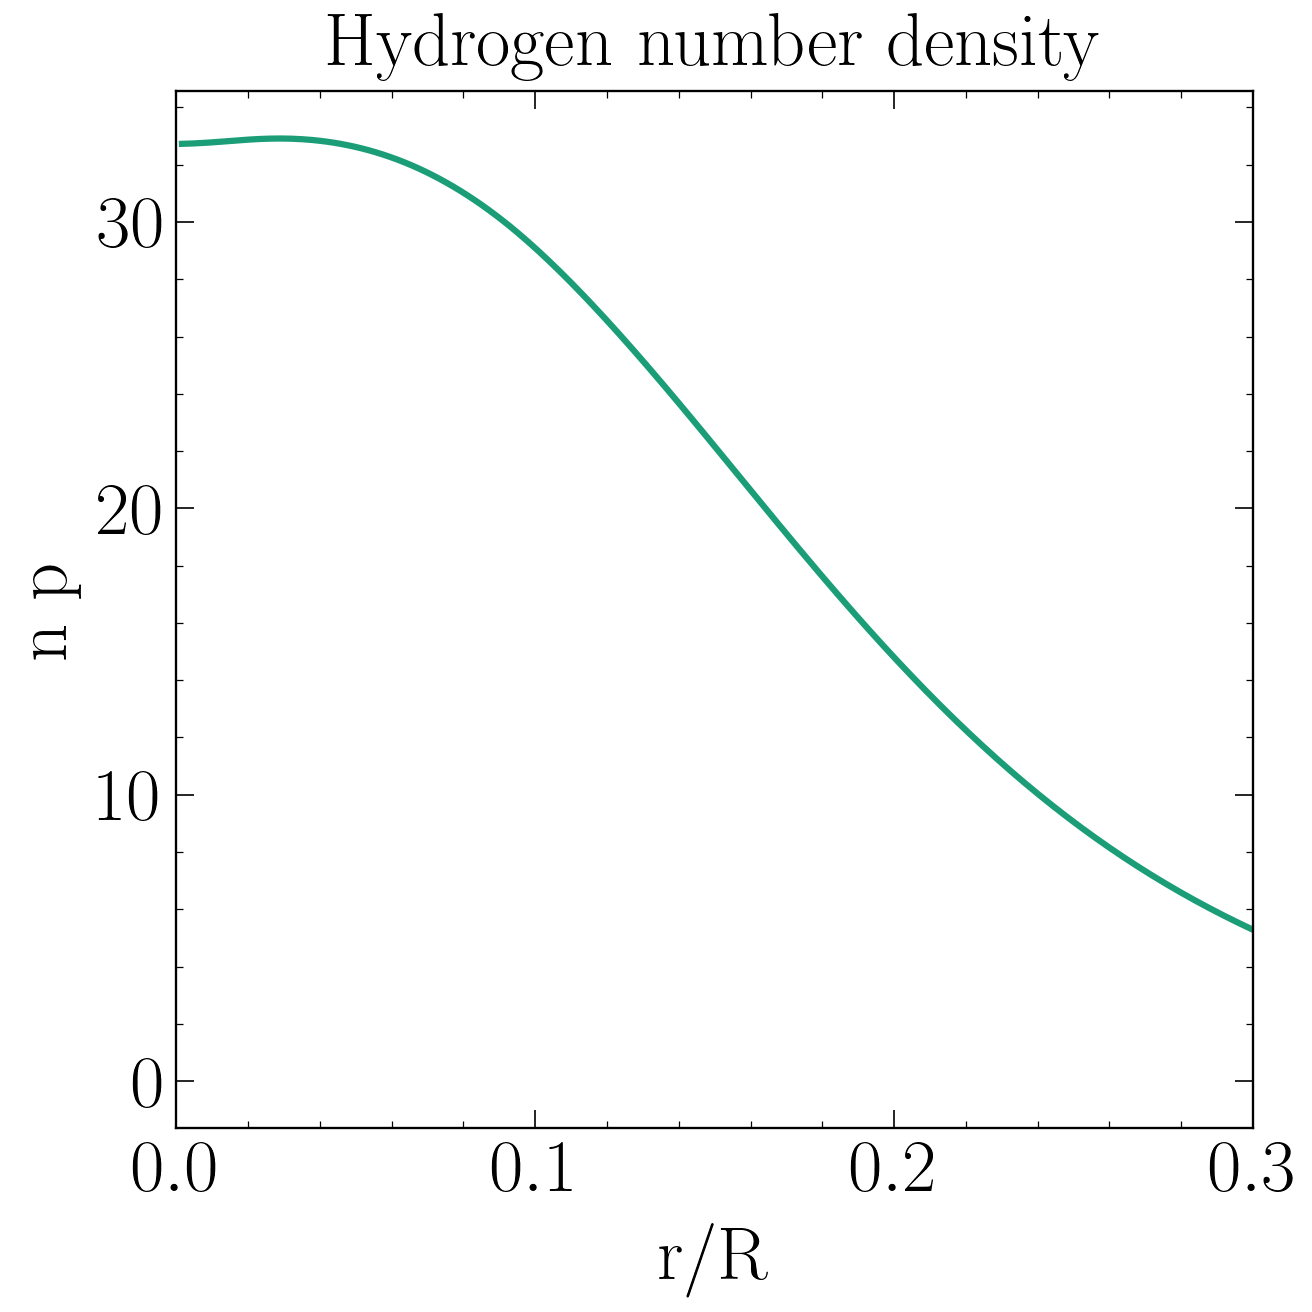

In [25]:
plotReaction(SSM_r,n2,r'r/R',r'n p',24,'Hydrogen number density','Images/Reaction Rates/Hydrogen_density')

## $^{14}$N + p

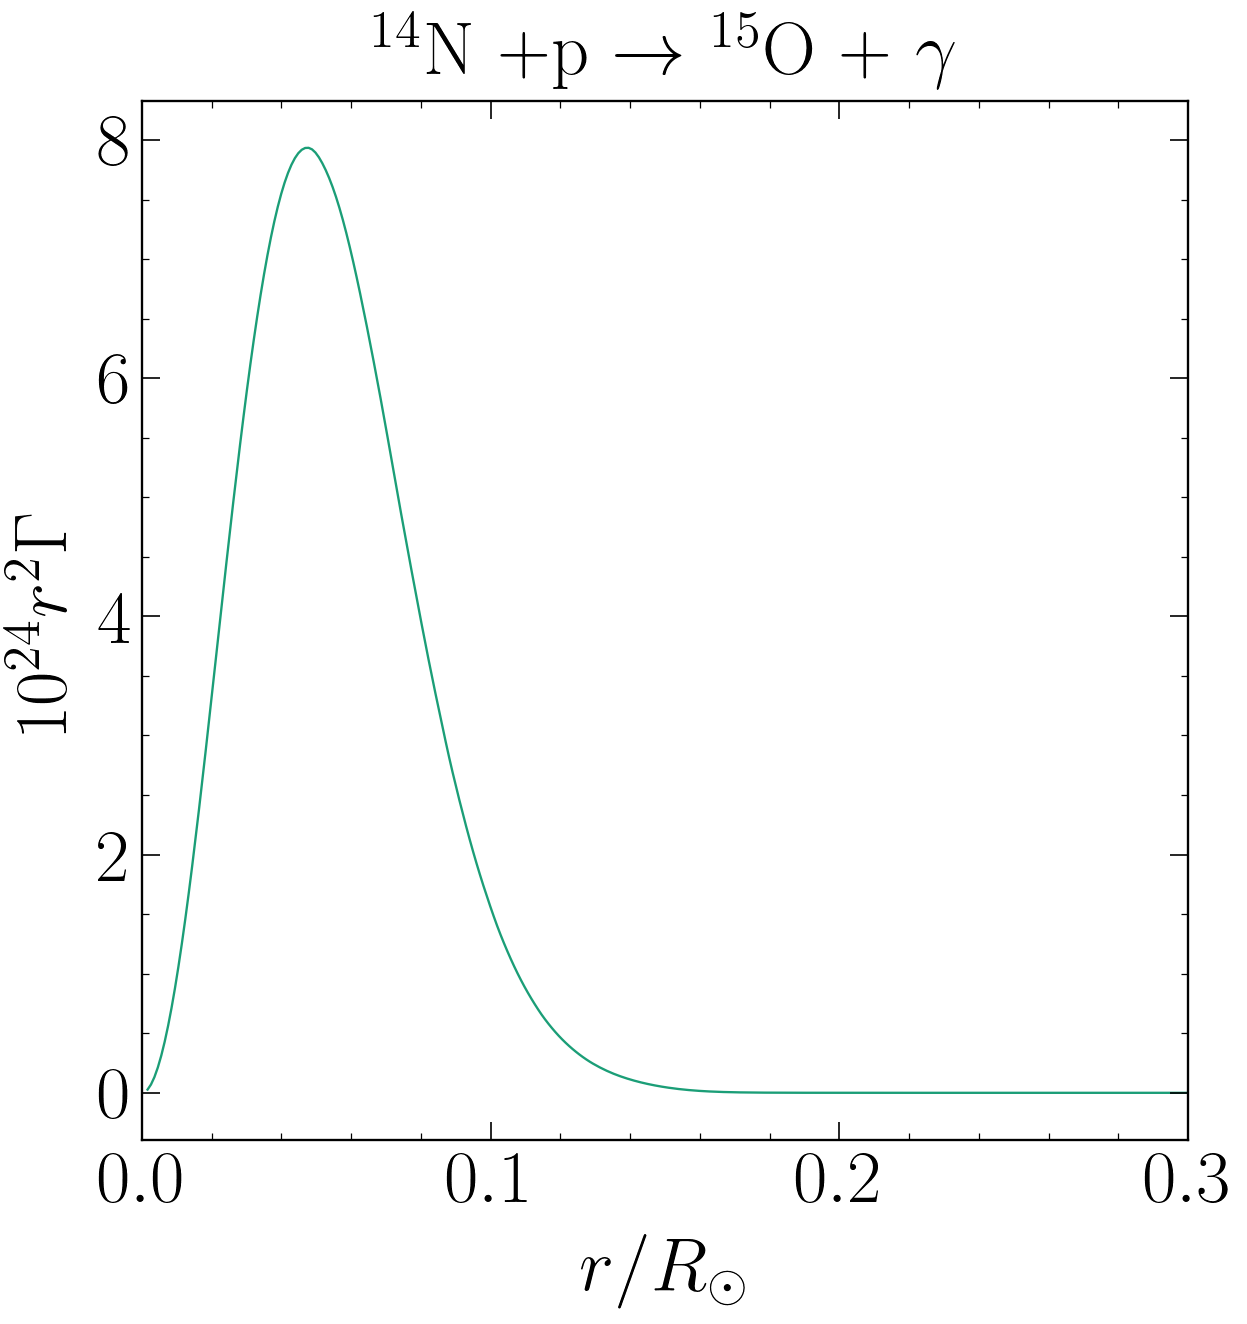

In [16]:
Z_N = 7
Z_H = 1
A_N = 14
A_H = 1
m_N14 = 2.325e-23 * u.g
m_H = 1.6738e-24 * u.g

N14p = reactionRate(SSM_N14, SSM_H, Z_N, Z_H, A_N, A_H, S114,S114_prime,S114_dbl_prime,m_N14,m_H)

title = r'$^{14}$N +p $\rightarrow$ $^{15}$O + $\gamma$'

plotReaction(SSM_r,N14p*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{24} r^2 \Gamma$',24,title)

## $^{16}$O + p

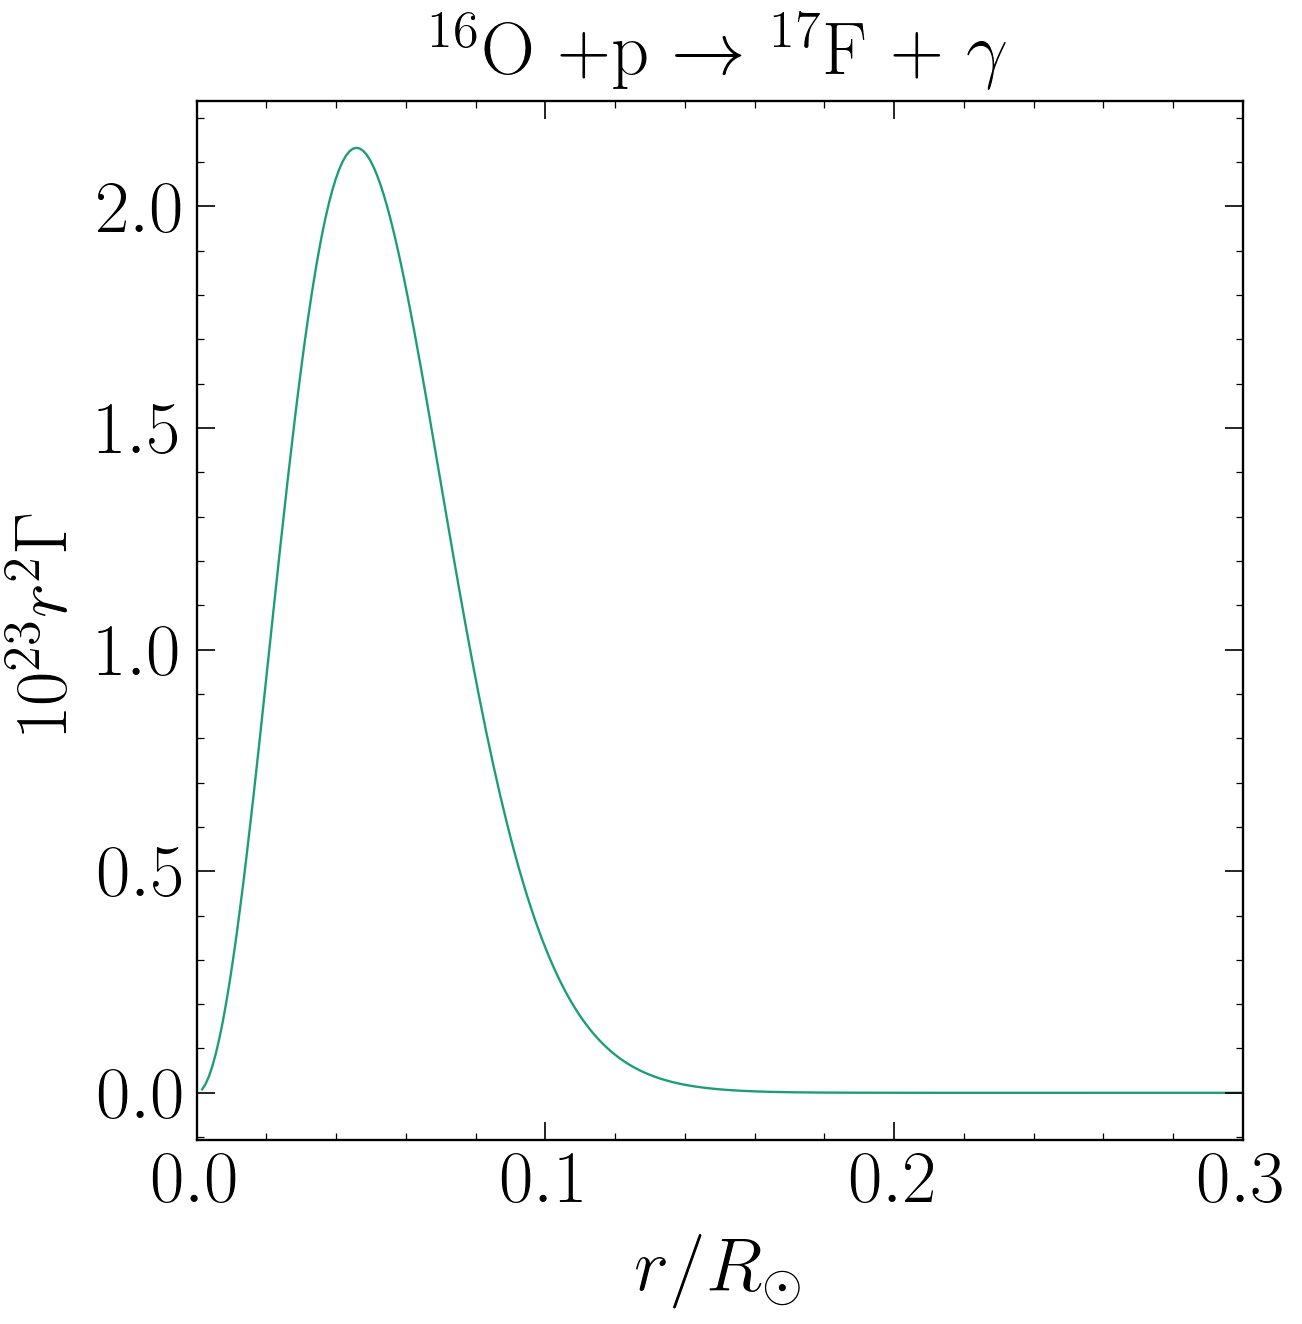

In [17]:
Z_O = 8
Z_H = 1
A_O = 16
A_H = 1
m_O16 = 2.656e-23 * u.g
m_H = 1.6738e-24 * u.g

O16p = reactionRate(SSM_O16, SSM_H, Z_O, Z_H, A_O, A_H, S116,S116_prime,S116_dbl_prime,m_O16,m_H)

title = r'$^{16}$O +p $\rightarrow$ $^{17}$F + $\gamma$'

plotReaction(SSM_r,O16p*SSM_radius_cm**2,r'$r/R_\odot$',r'$10^{23} r^2 \Gamma$',23,title)

In [21]:
def plot_CNO(rates,labels,normalizations,linestyles):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5),dpi=350)
    for i,y in enumerate(rates):
        ax.plot(SSM_r,y/(10**normalizations[i]) * SSM_radius_cm**2,label=labels[i],lw=1.5,ls=linestyles[i])
    
    ax.set_xlabel(r'$r/R_\odot$')
    ax.set_ylabel(r'$r^2 \Gamma$ [cm$^{-1}$ s$^{-1}$]')
    ax.set_title('Selected Reaction Rates of the CNO Bi-cycle')
    ax.set_xlim(0,0.3)
    
    ax.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('Images/Reaction Rates/cno_rates.pdf')
    plt.show()

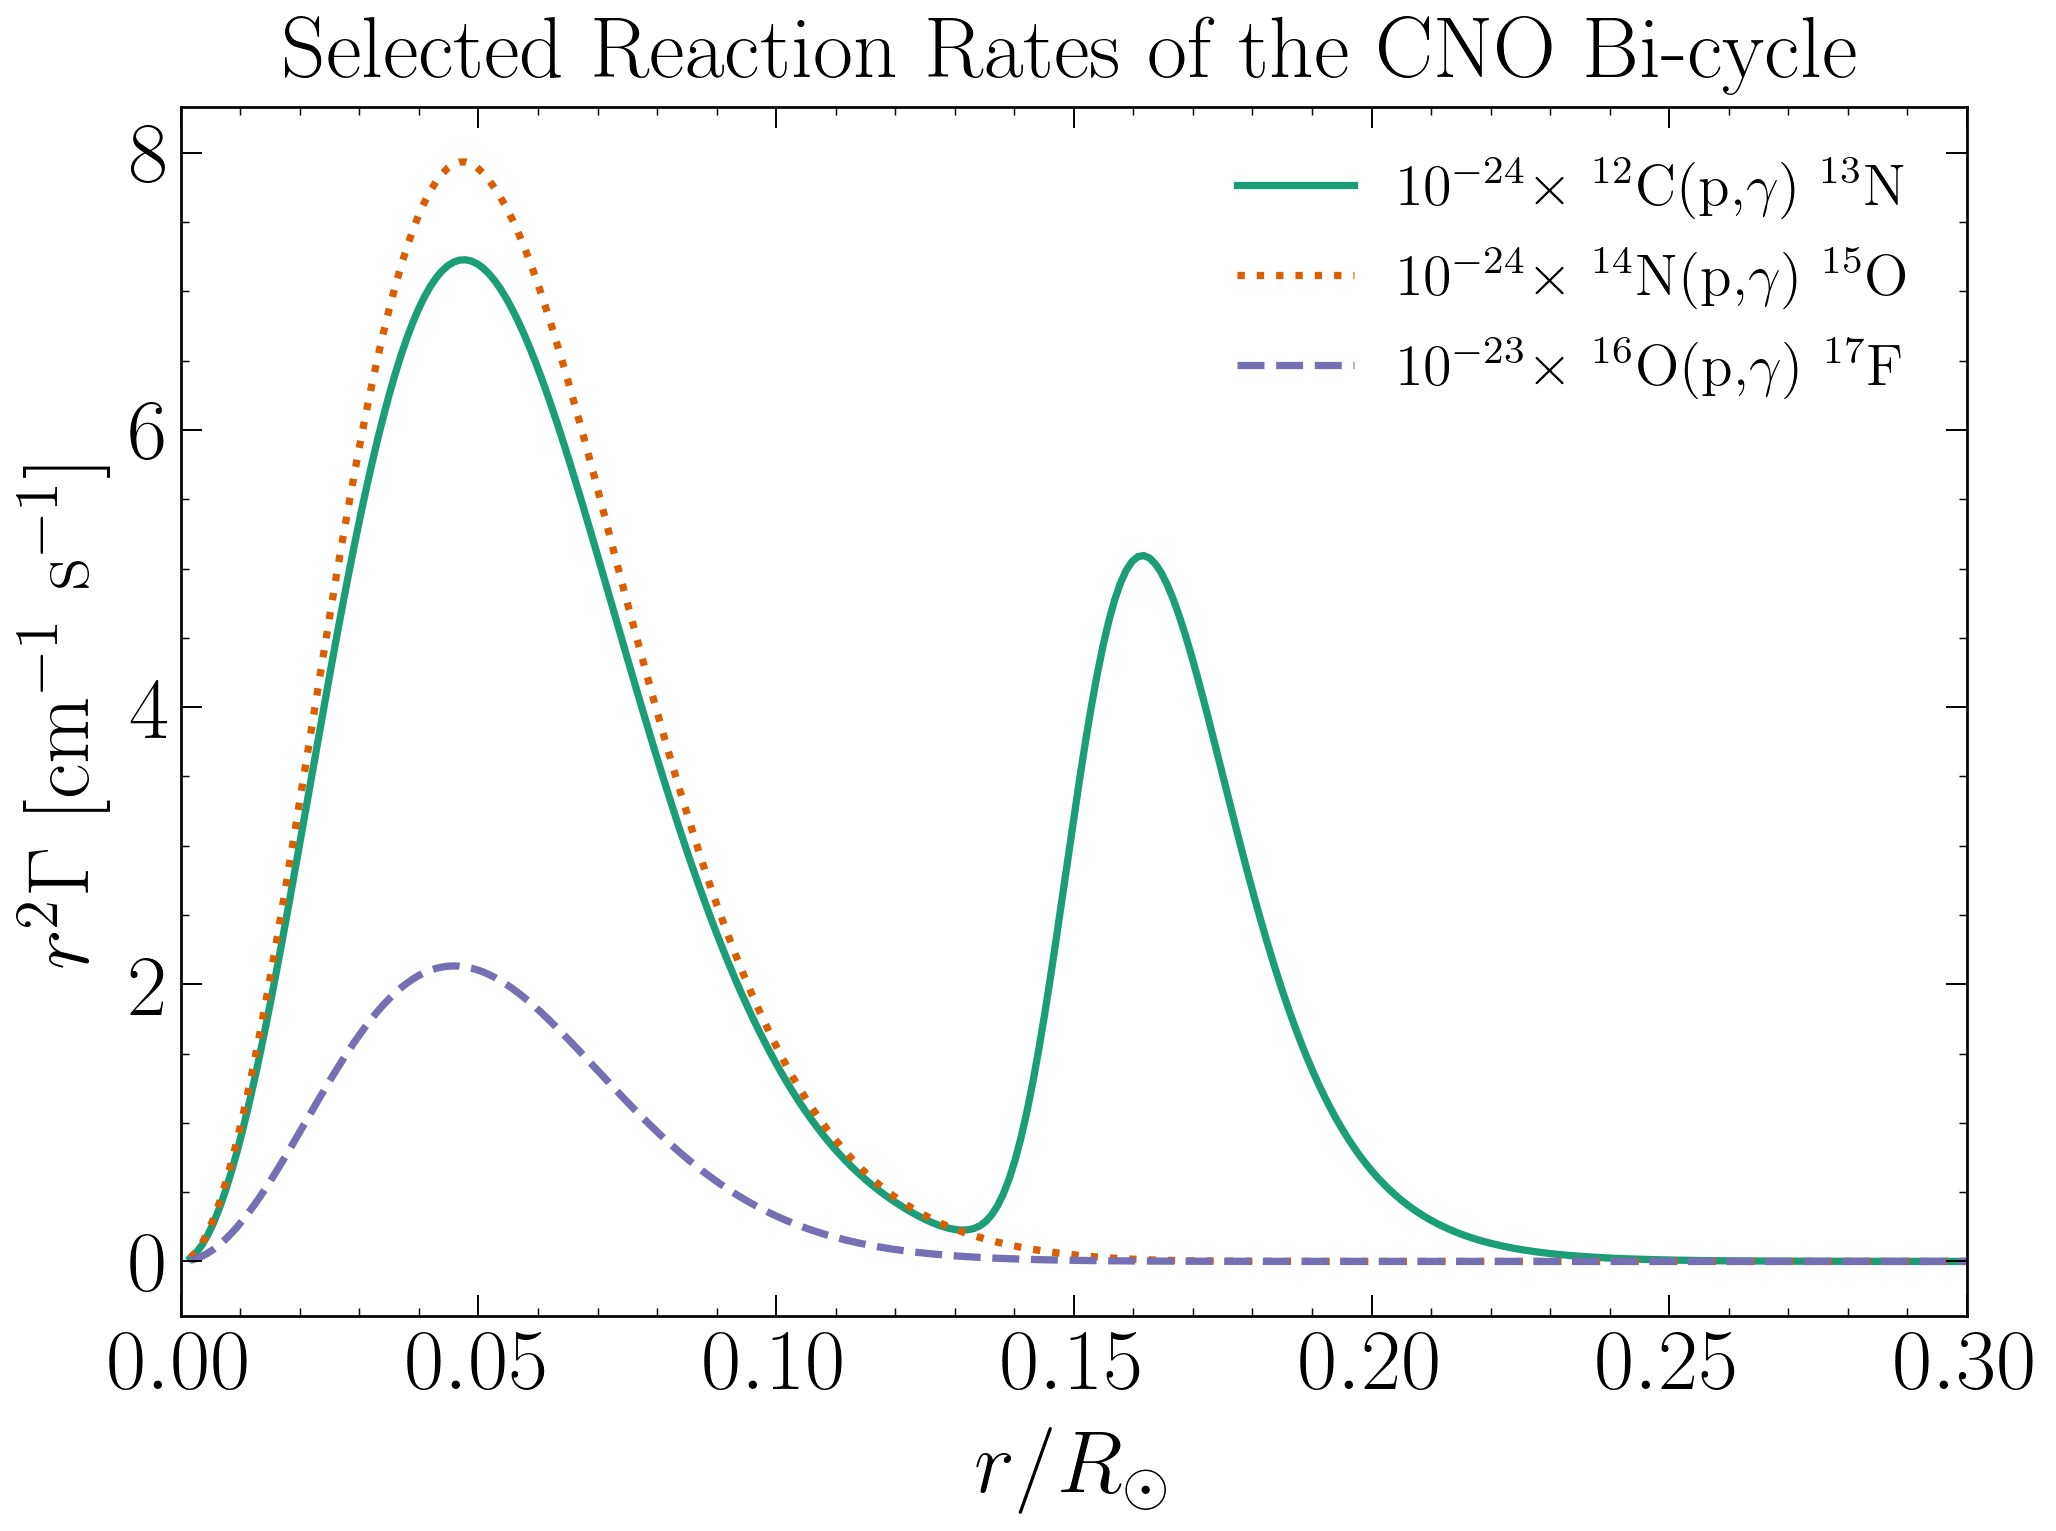

In [22]:
all_rates = [C12p,N14p,O16p]
all_labels = [r'$10^{-24} \times$ $^{12}$C(p,$\gamma$) $^{13}$N',r'$10^{-24} \times$ $^{14}$N(p,$\gamma$) $^{15}$O',r'$10^{-23} \times$ $^{16}$O(p,$\gamma$) $^{17}$F']
all_normalizations = [24,24,23]
all_linestyles = ['solid','dotted','dashed']
plot_CNO(all_rates,all_labels,all_normalizations,all_linestyles)